# Assessment

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib

In [15]:
# after we download and have the .csv in the directory, we read as follows::
path_of_data = pathlib.Path.cwd() / 'challenge_data.csv'
data = pd.read_csv(path_of_data)

## Part I – SQL/Data Handling

In [16]:
# we focus on cities that have at least 500 orders
total_orders_per_city = data.groupby('city').size()
subset = total_orders_per_city[total_orders_per_city >= 500]
cities_500 = list(subset.index)

In [17]:
# we select orders having the breakfast category and being in a major city
cond = (data['cuisine_parent'] == 'Breakfast') & (data['city'].isin(cities_500))
# we group-by per city, count orders, sort by value in a descending order and select the top-10 cities
cities_order_stats = list(data.loc[cond].groupby('city').size().sort_values(ascending=False).index[:10])

print('The cities with the most orders in the Breakfast category in a descending order are:')
print(cities_order_stats)

The cities with the most orders in the Breakfast category in a descending order are:
['Ηράκλειο Κρήτη', 'Πάτρα', 'Βόλος', 'Λάρισα', 'Καλαμάτα', 'Ξάνθη', 'Ιωάννινα', 'Χαλκίδα', 'Ρόδος', 'Αλεξανδρούπολη']


In [18]:
breakfast_users_stats = list(data.loc[cond, ['user_id', 'city']].drop_duplicates(subset=['user_id', 'city'])
                             .groupby(['city']).size().sort_values(ascending=False).index[:10])
print('The cities with the most users in the Breakfast category in a descending order are:')
print(breakfast_users_stats)

The cities with the most users in the Breakfast category in a descending order are:
['Ηράκλειο Κρήτη', 'Πάτρα', 'Βόλος', 'Λάρισα', 'Καλαμάτα', 'Ξάνθη', 'Ιωάννινα', 'Χανιά Κρήτη', 'Ρόδος', 'Χαλκίδα']


In [19]:
breakfast_user_ids = list(set(data.loc[cond, ['user_id', 'city']]
                              .drop_duplicates(subset=['user_id', 'city'])
                              .loc[:, 'user_id']))

In [20]:
# calculating average basket value per user
average_basket = data.loc[cond & (data['user_id'].isin(breakfast_user_ids))]\
        .groupby('city')\
        .agg({'basket': 'mean'})

In [21]:
# calculating top-10 basket_values
top_10_avg_basket_cities = list(average_basket.sort_values(by='basket', ascending=False).index[:10])
print('top-10 average basket cities are:')
print(top_10_avg_basket_cities)

top-10 average basket cities are:
['Κατερίνη', 'Κέρκυρα', 'Γρεβενά', 'Χανιά Κρήτη', 'Θήβα', 'Ιεράπετρα Κρήτη', 'Χαλκίδα', 'Κιλκίς', 'Λάρισα', 'Ρόδος']


##  Part II - User segmentation

In [22]:
# checking to see that all timestamps are in UTC timezone
utc_flag = data.loc[:, 'submit_dt'].apply(lambda x: 'UTC' not in x).any()
assert not utc_flag

In [23]:
# converting string to datetime
data['submit_dt'] = pd.to_datetime(data['submit_dt'])

# for each user we calculate the mean difference in days between consecutive orders
# a user with just one order does not have a proper value for this metric
group = data.groupby('user_id')
user_avg_frequency = group.apply(lambda x: x.sort_values(by='submit_dt', ascending=True)['submit_dt']
                                 .diff().mean())

In [24]:
user_avg_frequency = user_avg_frequency.apply(lambda d: d.days)
# for the not timestamp values we set the max value + 10
user_avg_frequency = user_avg_frequency.fillna(np.max(user_avg_frequency) + 10)

# first list of user_ids
# calculating the users with a average frequency of less or equal than 5 days
user_segmentation_freq1 = list(user_avg_frequency[user_avg_frequency <= 5].index)

Text(0.5, 1.0, '')

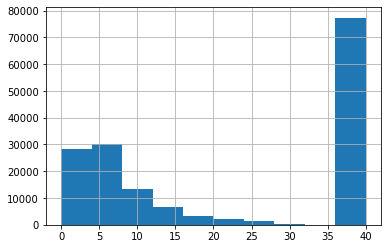

In [25]:
# %matplotlib qt
# plotting a histogram so we can inspect the data and understand its distribution
user_avg_frequency.hist()
plt.title('')

In [26]:
# frequency second metric: count orders by user
# counting how many orders per user we have
user_count_orders = data.groupby('user_id').agg({'order_id': 'count'})

Text(0.5, 1.0, '')

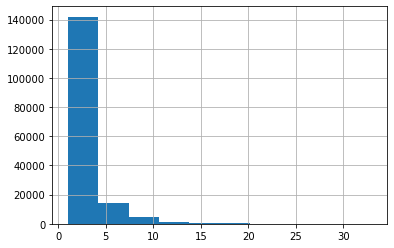

In [27]:
user_count_orders.hist()
plt.title('')

In [28]:
# second list of user ids
user_segmentation_freq2 = list(user_count_orders[user_count_orders['order_id'] >= 5].index)

In [29]:
# average basket
avg_basket = data.groupby('user_id').agg({'basket': 'mean'})
# selecting users with an average basket value of 7 euros or lower
user_segmentation_basket = list(avg_basket[avg_basket['basket'] <= 7].index)

Text(0.5, 1.0, '')

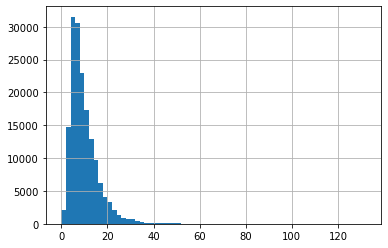

In [30]:
# plotting
avg_basket.hist(bins=range(0, int(max(avg_basket.values)[0]), 2))
plt.title('')

In [31]:
# this is an additional metric to measure users that have placed breakfast orders
breakfast_data = data.loc[data['cuisine_parent'] == 'Breakfast', :]
breakfast_stats = breakfast_data.groupby('user_id').agg({'order_id': 'count'})
# selecting users with low (6) number of breakfast orders
less_frequent_breakfast_users = list(breakfast_stats[breakfast_stats['order_id'] <= 6].index)

Text(0.5, 1.0, '')

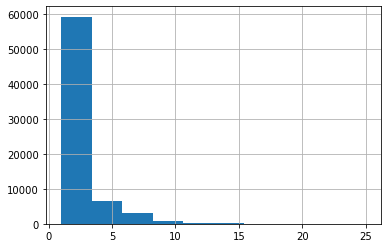

In [38]:
# plotting
breakfast_stats.hist()
plt.title('')

In [39]:
# users with at least one breakfast order
breakfast_users = list(set(breakfast_data['user_id']))

## Calculating the final target audience

#### We can see how the target is audience is reduced step-by-step resulting into a set of 7298 users

In [48]:
all_users = len(list(set(data['user_id'])))
print(all_users)

list_a = list(set(user_segmentation_freq1) & set(user_segmentation_freq2))
print(len(list_a))

list_b = list(set(list_a) & set(user_segmentation_basket))
print(len(list_b))

list_c = list(set(list_b) & set(breakfast_users))
print(len(list_c))

final_list = list(set(list_c) & set(less_frequent_breakfast_users))
print(len(final_list))

162954
19188
10505
9757
7298
